In [1]:
import torch
device = 'cpu'

In [2]:
model = torch.load("/net/scratch/zsarwar/exps_t/GPT_experts-4-topk-1-layers12-heads-12/-master-0-a14b5f2b28bda98b69695a31d33ea777/checkpoints/global_step5000/mp_rank_00_model_states.pt", map_location=device)

/tmp/ipykernel_3455205/1560415127.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("/net/scratch/zsarwar/exps_t/GPT_experts-4-topk-1-layers12-heads-12/

In [3]:
model['module'].keys()

odict_keys(['sequential.0.word_embeddings.weight', 'sequential.2.input_layernorm.weight', 'sequential.2.input_layernorm.bias', 'sequential.2.attention.query_key_value.weight', 'sequential.2.attention.query_key_value.bias', 'sequential.2.attention.dense.weight', 'sequential.2.attention.dense.bias', 'sequential.2.post_attention_layernorm.weight', 'sequential.2.post_attention_layernorm.bias', 'sequential.2.mlp.router.layer.weight', 'sequential.2.mlp.experts.minion_experts.router.layer.weight', 'sequential.2.mlp.experts.minion_experts.experts.mlp.w1_A', 'sequential.2.mlp.experts.minion_experts.experts.mlp.w1_B', 'sequential.2.mlp.experts.minion_experts.experts.mlp.w2_A', 'sequential.2.mlp.experts.minion_experts.experts.mlp.w2_B', 'sequential.2.mlp.experts.mlp.w1', 'sequential.2.mlp.experts.mlp.w2', 'sequential.3.input_layernorm.weight', 'sequential.3.input_layernorm.bias', 'sequential.3.attention.query_key_value.weight', 'sequential.3.attention.query_key_value.bias', 'sequential.3.attentio

In [ ]:
model['module']['sequential.2.mlp.experts.minion_experts.experts.mlp.w1_A'].shape


torch.Size([256, 768])

In [7]:
model['module']['sequential.2.mlp.experts.minion_experts.experts.mlp.w1_B'].shape

torch.Size([256, 3072])

In [9]:
model['module']['sequential.2.mlp.experts.minion_experts.experts.mlp.w2_A'].shape

torch.Size([256, 3072])

In [8]:
model['module']['sequential.2.mlp.experts.minion_experts.experts.mlp.w2_B'].shape

torch.Size([256, 768])

In [11]:
model['module']['sequential.2.mlp.experts.mlp.w1'].shape


torch.Size([9216, 768])

In [12]:
model['module']['sequential.2.mlp.experts.mlp.w2'].shape


torch.Size([9216, 768])

In [14]:
9216 * 768 * 2

14155776

In [10]:
(256 * 768)*2 + (256 * 3072)*2

1966080

In [19]:
w1_A = model['module']['sequential.2.mlp.experts.mlp.loras.w1_A'].float()

In [20]:
w1_B = model['module']['sequential.2.mlp.experts.mlp.loras.w1_B'].float()

In [23]:
import torch
import matplotlib.pyplot as plt

def visualize_expert_weights(weights_tensor, weight_shape=(768, 4), max_experts=16, cmap='viridis'):
    num_experts = weights_tensor.size(0)
    flattened_size = weights_tensor.size(1)
    assert weight_shape[0] * weight_shape[1] == flattened_size, "Mismatch in flatten size and shape"

    num_to_plot = min(max_experts, num_experts)
    cols = 4
    rows = (num_to_plot + cols - 1) // cols

    # Calculate global min and max across all weights to set a shared color scale
    global_min = weights_tensor.min().item()
    global_max = weights_tensor.max().item()

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))

    for i in range(num_to_plot):
        reshaped = weights_tensor[i].view(weight_shape)
        ax = axes[i // cols, i % cols] if rows > 1 else axes[i % cols]
        im = ax.imshow(
            reshaped.cpu().numpy(), 
            aspect='auto', 
            cmap=cmap, 
            vmin=global_min, 
            vmax=global_max
        )
        ax.set_title(f"Expert {i}", fontsize=10)
        ax.set_xlabel("Out Features")
        ax.set_ylabel("In Features")

    # Add a single shared colorbar
    fig.subplots_adjust(right=0.88)
    cbar_ax = fig.add_axes([0.91, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    fig.colorbar(im, cax=cbar_ax)

    # Hide unused axes
    for j in range(num_to_plot, rows * cols):
        ax = axes[j // cols, j % cols] if rows > 1 else axes[j % cols]
        ax.axis("off")

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

/tmp/ipykernel_1199726/2299538416.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


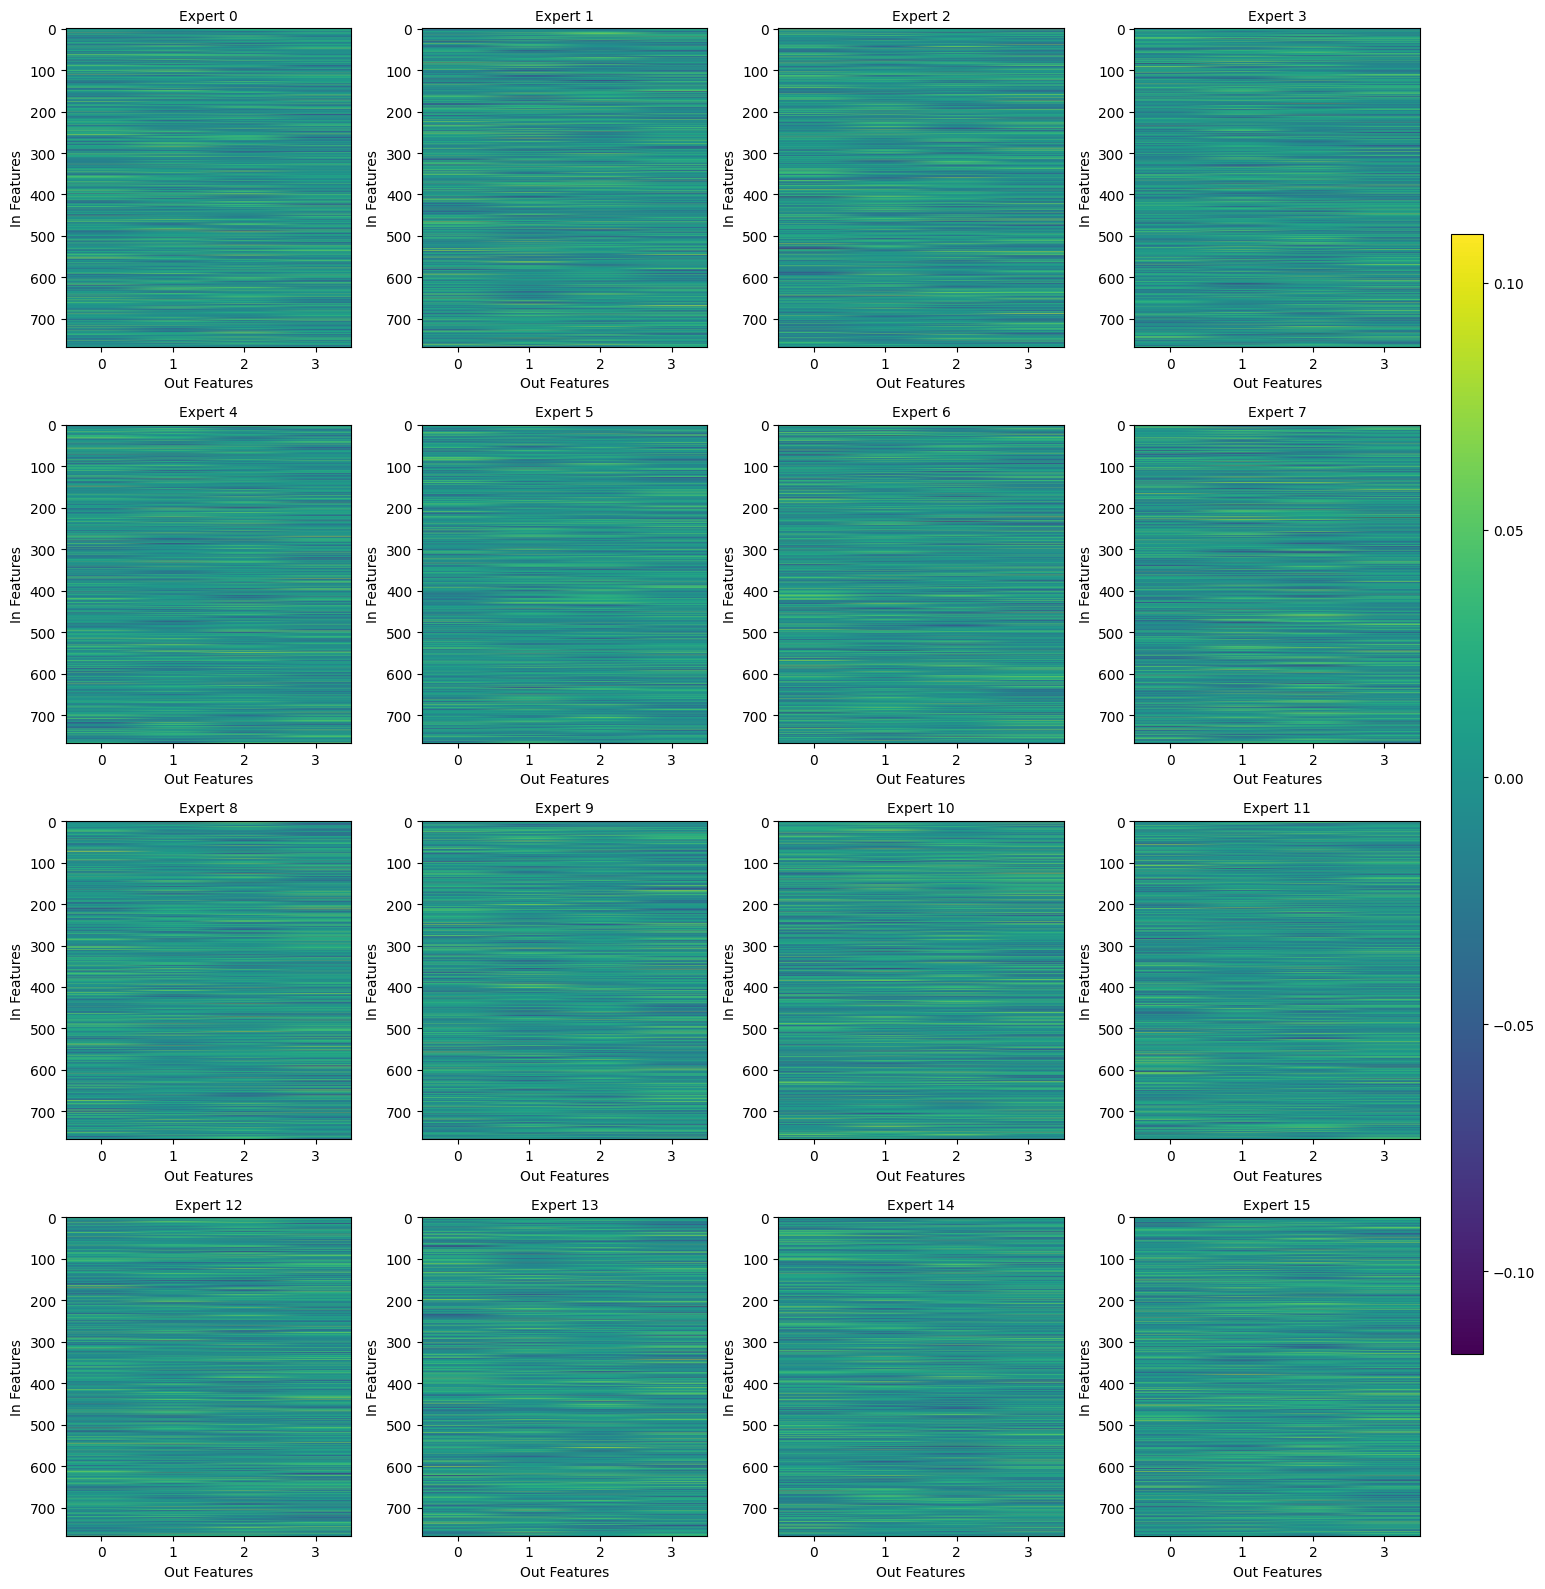

In [24]:
visualize_expert_weights(weights_tensor=w1_A, weight_shape=(768, 4), max_experts=16)

In [25]:
import torch
import matplotlib.pyplot as plt

def plot_covariance(weights_tensor):
    """
    weights_tensor: Tensor of shape [num_experts, flattened_weights]
    Computes and plots the covariance matrix across flattened weights.
    """

    # Center the data (zero mean per column)
    mean_centered = weights_tensor - weights_tensor.mean(dim=0, keepdim=True)

    # Compute covariance matrix: [D x D]
    cov_matrix = mean_centered.T @ mean_centered / (weights_tensor.shape[0] - 1)

    # Convert to numpy for plotting
    cov_matrix_np = cov_matrix.cpu().numpy()

    # Plot the covariance matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(cov_matrix_np, cmap='coolwarm', aspect='auto')
    plt.colorbar(label='Covariance')
    plt.title("Covariance Matrix of Expert Weights")
    plt.xlabel("Weight Dimension")
    plt.ylabel("Weight Dimension")
    plt.tight_layout()
    plt.show()

    return cov_matrix

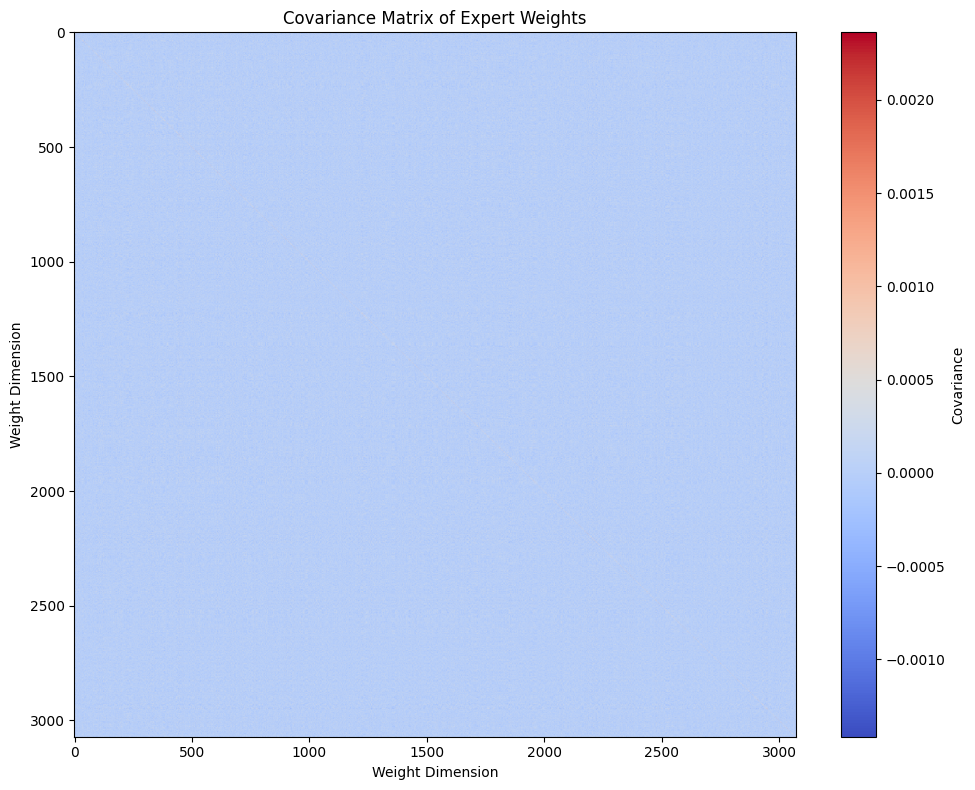

In [26]:
cov_matrix = plot_covariance(w1_A)

In [27]:
import torch
import matplotlib.pyplot as plt

def expert_weight_covariance(weights_tensor, plot=True):
    """
    weights_tensor: [num_experts, flattened_dim]
    Returns a [num_experts x num_experts] covariance matrix.
    """
    # Mean-center each expert's weight vector
    centered = weights_tensor - weights_tensor.mean(dim=1, keepdim=True)

    # Compute covariance between experts
    cov_matrix = (centered @ centered.T) / (weights_tensor.shape[1] - 1)

    if plot:
        plt.figure(figsize=(6, 5))
        plt.imshow(cov_matrix.cpu().numpy(), cmap='coolwarm', interpolation='nearest')
        plt.title("Expert-to-Expert Covariance")
        plt.colorbar(label="Covariance")
        plt.xlabel("Expert")
        plt.ylabel("Expert")
        plt.tight_layout()
        plt.show()

    return cov_matrix

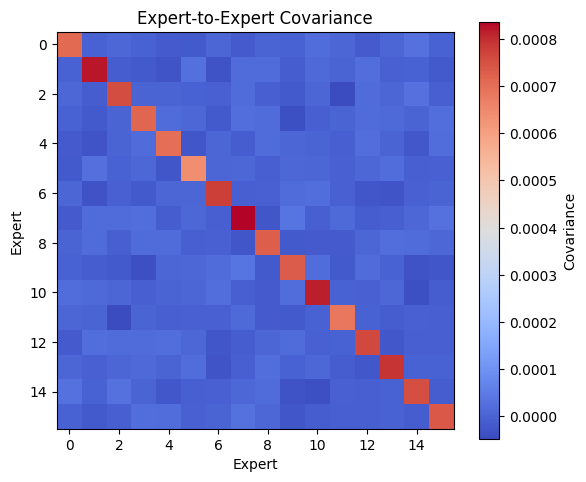

In [29]:
# weights: [16, 3072]
cov = expert_weight_covariance(w1_A)